<a href="https://colab.research.google.com/github/A-Tamerlan/ML_Final_Project/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22cats_v_dogs_classification_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Firstly, upload the kaggle token and download the necessary competition to work on.

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tamerlanabaideldinov","key":"459d5b4b4de497da9439f3d1c42ff05e"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 805M/814M [00:03<00:00, 283MB/s]
100% 814M/814M [00:03<00:00, 260MB/s]


Then, we need to unzip the dataset and its contents to gain access to images of cats and dogs.

In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats-redux-kernels-edition.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('/content/train')
zip_ref.close()

In [9]:
zip_ref = zipfile.ZipFile('/content/test.zip', 'r')
zip_ref.extractall('/content/test')
zip_ref.close()

Now we import the necessary libraries for building a CNN model.

In [30]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.preprocessing import image
from glob import glob
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import csv

Initialize the path that contains the training images for further use and arrays for images themselves and their corresponding labels.

In [11]:
path = '/content/train/train'

dogs, cats = [], []
y_dogs, y_cats = [], []

Load the images into arrays based on the names within the file.

In [15]:
def load_dogs():
    dog_path = os.path.join(path, 'dog*')
    for dog_img in glob(dog_path):
        dog = cv2.imread(dog_img)
        dog = cv2.cvtColor(dog, cv2.COLOR_BGR2GRAY)
        dog = cv2.resize(dog, (96, 96))
        dog = image.img_to_array(dog)
        dogs.append(dog)

In [16]:
def load_cats():
    cat_path = os.path.join(path, 'cat*')
    for cat_img in glob(cat_path):
        cat = cv2.imread(cat_img)
        cat = cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY)
        cat = cv2.resize(cat, (96, 96))
        cat = image.img_to_array(cat)
        cats.append(cat)

In [17]:
load_dogs()
load_cats()

Just to be sure, we check the sizes of the generated arrays with images.

In [18]:
print('Lenght of our dogs array: {}\nLenght of our cats array: {}'.format(len(dogs),len(cats)))

Lenght of our dogs array: 12500
Lenght of our cats array: 12500


Generate the labels for the dataset based on the description in the competition

In [19]:
classes = ['dog', 'cat']

In [20]:
y_dogs = [1 for item in enumerate(dogs)]
y_cats = [0 for item in enumerate(cats)]

In [21]:
print('Len of dogs labels: {}\nLen of cats labels: {}'.format(len(y_dogs), len(y_cats)))

Len of dogs labels: 12500
Len of cats labels: 12500


Convert the arrays and normalize the images for the input.

In [22]:
dogs = np.asarray(dogs).astype('float32')
cats = np.asarray(cats).astype('float32')
y_dogs = np.asarray(y_dogs).astype('int32')
y_cats = np.asarray(y_cats).astype('int32')
dogs /= 255
cats /= 255

In [23]:
X = np.concatenate((dogs,cats), axis=0)
y = np.concatenate((y_dogs, y_cats), axis=0)

When the preprocessing is finished, we can start to build our CNN model with 3 filters of kernel size = 2x2 and stride = 2, followed by 2 Fully Connected layers with 128 and 64 nodes respectively. The input is of size 96x96 with 1 grayscale channel. Every convolutional and fully connected layer uses a ReLu function that ensures non-linearity. The output layer was meant to use a softmax function, but in binary classification it will be equivalent to sigmoid, so we chose the latter instead.

In [25]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(96,96,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

A short summary of the model:

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        320       
                                                                 
 batch_normalization_3 (Bat  (None, 94, 94, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 45, 45, 64)        256       
 chNormalization)                                                
                                                      

Compile the model using the Stochastic Gradient Descent as optimizer and estimate loss using a binary cross-entropy.

In [27]:
model.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])

After experimenting, we decided to add an Early Stopping optimization that monitors validation accuracy and has a patience of 4 epochs in order to avoid overfitting. Validation portion is set to be 20%.

In [28]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
history = model.fit(X, y, epochs=30, callbacks=[callback], validation_split=.2)

Epoch 1/30
625/625 [==============================] - 22s 14ms/step - loss: 0.5871 - accuracy: 0.6905 - val_loss: 0.8778 - val_accuracy: 0.3832
Epoch 2/30
625/625 [==============================] - 8s 13ms/step - loss: 0.4792 - accuracy: 0.7724 - val_loss: 1.0102 - val_accuracy: 0.4112
Epoch 3/30
625/625 [==============================] - 8s 13ms/step - loss: 0.4120 - accuracy: 0.8109 - val_loss: 0.8604 - val_accuracy: 0.4950
Epoch 4/30
625/625 [==============================] - 8s 13ms/step - loss: 0.3580 - accuracy: 0.8374 - val_loss: 0.6994 - val_accuracy: 0.6616
Epoch 5/30
625/625 [==============================] - 9s 14ms/step - loss: 0.3000 - accuracy: 0.8705 - val_loss: 0.6370 - val_accuracy: 0.7088
Epoch 6/30
625/625 [==============================] - 8s 13ms/step - loss: 0.2351 - accuracy: 0.9027 - val_loss: 0.7805 - val_accuracy: 0.6680
Epoch 7/30
625/625 [==============================] - 9s 14ms/step - loss: 0.1800 - accuracy: 0.9260 - val_loss: 1.4873 - val_accuracy: 0.493

Evaluation of the model shows a decent accuracy.

In [29]:
scores = model.evaluate(X, y, verbose=2)
print('Model Accuracy\n{}: {}%'.format(model.metrics_names[1], scores[1]*100))

782/782 - 3s - loss: 0.2970 - accuracy: 0.9272 - 3s/epoch - 4ms/step
Model Accuracy
accuracy: 92.72400140762329%


The block below is used to predict the labels on a test dataset and write it into a csv file.

In [40]:
path = '/content/test/test/1*'

In [41]:
df = []
for df_img in glob(path):
    dfsample = cv2.imread(df_img)
    dfsample = cv2.cvtColor(dfsample, cv2.COLOR_BGR2GRAY)
    dfsample = cv2.resize(dfsample, (96, 96))
    dfsample = image.img_to_array(dfsample)
    df.append(dfsample)

In [42]:
df = np.asarray(df).astype('float32')
df /= 255

In [51]:
results = model.predict(df)
results = np.asarray(results).astype('float64')
with open('result.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ["id", "label"]

    writer.writerow(field)
    for i in range(len(results)):
      writer.writerow([i, results[i]])

113/113 [==============================] - 0s 4ms/step


In [52]:
from google.colab import files
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Below are some graphs that we used to visualize the training process and pinpoint the flaws.

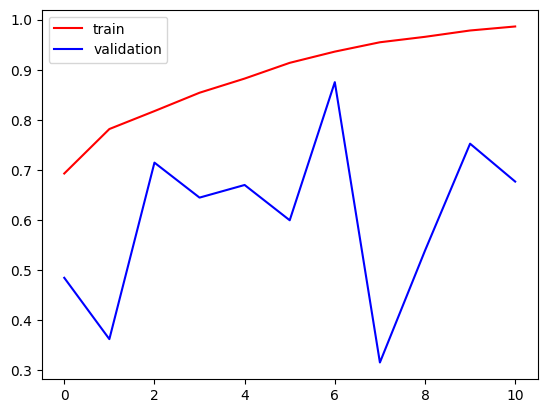

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

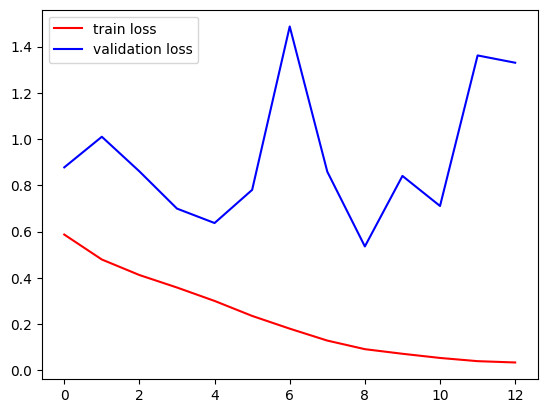

In [50]:
plt.plot(history.history['loss'],color='red',label='train loss')
plt.plot(history.history['val_loss'],color='blue',label='validation loss')
plt.legend()
plt.show()